<a href="https://colab.research.google.com/github/kevinzakka/clip_playground/blob/main/CLIP_Zero_shot_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP Zero-shot Detector

This Colab notebook demos a smarter detector that generates bounding boxes using [selective search](http://cs.brown.edu/people/pfelzens/papers/seg-ijcv.pdf), then filters them out with NMS using CLIP's image-text similarity score.

In [1]:
#@title Install dependencies

#@markdown Please execute this cell by pressing the _Play_ button 
#@markdown on the left.

#@markdown **Note**: This installs the software on the Colab 
#@markdown notebook in the cloud and not on your computer.

%%capture
!pip install ftfy regex tqdm matplotlib selectivesearch
!pip install git+https://github.com/openai/CLIP.git

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import urllib.request
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import clip
from PIL import Image
from torchvision import transforms
import selectivesearch

In [2]:
#@title Helper functions

#@markdown Some helper functions for loading, patchifying and visualizing images.

def load_image(img_path, resize=None, pil=False):
    image = Image.open(image_path).convert("RGB")
    if resize is not None:
        image = image.resize((resize, resize))
    if pil:
        return image
    image = np.asarray(image).astype(np.float32) / 255. 
    return image

# Reference: https://github.com/rbgirshick/fast-rcnn/blob/master/lib/utils/nms.py
def nms(dets, thresh):
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep

# Reference: https://github.com/rbgirshick/py-faster-rcnn/blob/master/tools/demo.py
def vis_detections(im, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    top_idx = dets[:, -1].argmax()

    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red' if i == top_idx else 'green', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:.3f}'.format(score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')
    plt.axis('off')
    plt.tight_layout()
    plt.draw()
    plt.show()

Image resolution: (431, 612, 3)


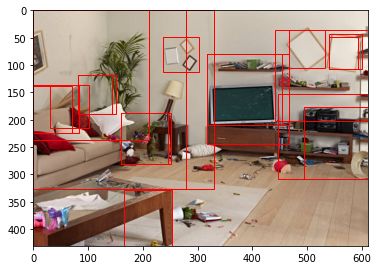

In [3]:
#@title Image and Selective Search Settings { run: "auto" }

image_url = 'https://media.istockphoto.com/photos/messy-living-room-with-damage-picture-id1007757070?k=6&m=1007757070&s=612x612&w=0&h=42lIXYgYC-L0CnSkB-XDM1qDSiUw1nbEOaLhnwUfR_4=' #@param {type:"string"}
#@markdown ---
#@markdown #### Selective search settings
scale =  200#@param {type:"integer"}
sigma =  0.8#@param {type:"number"}
min_size = 50#@param {type:"integer"}

# Download the image from the web.
image_path = 'image.png'
urllib.request.urlretrieve(image_url, image_path)

img = load_image(image_path)
print(f"Image resolution: {img.shape}")
img_lbl, regions = selectivesearch.selective_search(img, scale=scale, sigma=sigma, min_size=min_size)

candidates = set()
for r in regions:
    # excluding same rectangle (with different segments)
    if r['rect'] in candidates:
        continue
    # excluding regions smaller than 2000 pixels
    if r['size'] < 2000:
        continue
    # distorted rects
    x, y, w, h = r['rect']
    if w / h > 1.2 or h / w > 1.2:
        continue
    candidates.add(r['rect'])

candidates = list(candidates)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(img)
for x, y, w, h in candidates:
    rect = mpatches.Rectangle(
        (x, y), w, h, fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)

plt.show()

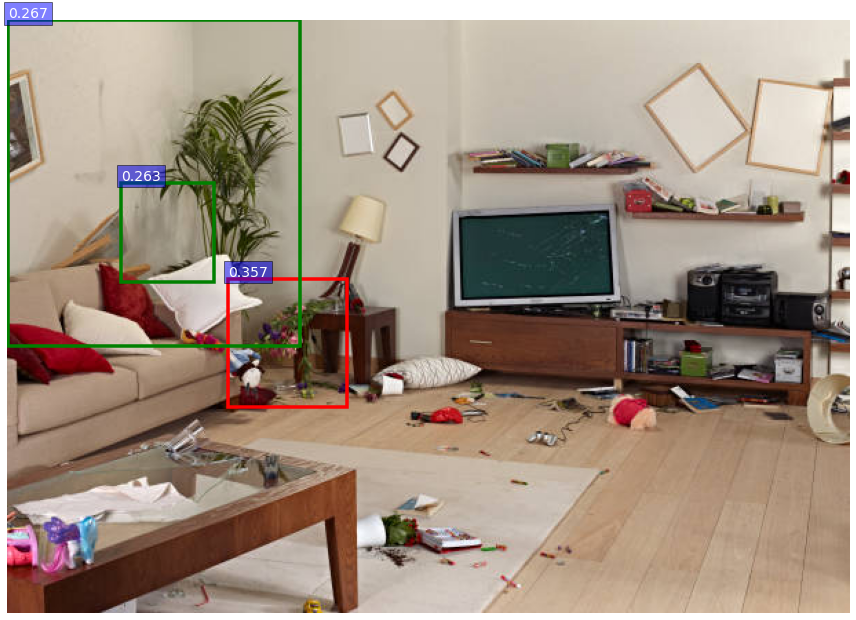

In [6]:
#@title Detect

clip_model = "ViT-B/32" #@param ["RN50", "RN101", "RN50x4", "RN50x16", "ViT-B/32", "ViT-B/16"]
image_caption = 'the plants in the vase' #@param {type:"string"}
nms_threshold =  0.5#@param {type:"number"}
viz_threshold = 0.2#@param {type:"number"}

# Load CLIP model.
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(clip_model, device=device, jit=False)

batch = []
for box in candidates:
    x, y, w, h = box
    patch = (img[y:y+h, x:x+w] * 255.).astype(np.uint8)
    patch = Image.fromarray(patch).convert("RGB")
    patch = preprocess(patch).unsqueeze(0)
    batch.append(patch)
batch = torch.cat(batch, dim=0).to(device)

text_input = clip.tokenize([image_caption]).to(device)

with torch.no_grad():
    patch_embs = model.encode_image(batch)
    text_embs = model.encode_text(text_input)
    patch_embs = patch_embs / patch_embs.norm(dim=-1, keepdim=True)
    text_embs = text_embs / text_embs.norm(dim=-1, keepdim=True)
    sim = model.logit_scale.exp() * patch_embs @ text_embs.t()

scores = sim.squeeze().cpu().numpy()

# Normalize scores to 0-1.
scores = (scores - scores.min()) / scores.max()

dets = []
for box, score in zip(candidates, scores):
    x, y, w, h = box
    x1 = x
    x2 = x1 + w
    y1 = y
    y2 = y1 + h
    dets.append([x1, y1, x2, y2, score])
dets = np.asarray(dets)

keep = nms(dets, nms_threshold)

dets_keep = dets[keep]

vis_detections(img, dets_keep, thresh=viz_threshold)